80.ID番号への変換

In [1]:
# 問題50と同じ
import pandas as pd
import re
from sklearn.model_selection import train_test_split
 
df = pd.read_csv("../NLP100_70~79/NewsAggregatorDataset/newsCorpora.csv", sep="\t", header=None,
                 names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

data = df.replace('"', "'")

publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

data['TITLE'] = data['TITLE'].apply(preprocessing)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64
検証データ
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64
評価データ
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64


In [2]:
from collections import defaultdict

# 単語の出現頻度を調べる
d = defaultdict(int)
for text in train['TITLE']:
    for word in text.split():
        d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True) # 出現頻度の降順にソート

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1} # 出現頻度が2回以上の単語を辞書に登録

for i, cnt in enumerate(word2id.items()):
    if i >= 20:
        break
    print(cnt[0], cnt[1])

to 1
0 2
in 3
as 4
on 5
UPDATE 6
for 7
The 8
of 9
US 10
To 11
the 12
and 13
In 14
Of 15
at 16
a 17
With 18
A 19
Is 20


In [3]:
# 辞書を用いて単語をID番号に変換、辞書にない単語は0に置換
def tokenizer(text, word2id=word2id, unk=0):
    return [word2id.get(word, unk) for word in text.split()]

# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Exxon Report Claims World Highly Unlikely To Limit Fossil Fuels Despite Risks
ID列: [5056, 144, 783, 278, 0, 5057, 11, 4056, 5058, 0, 1046, 1975]


81.RNNによる予測

In [4]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, device):
        hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
        return hidden

In [5]:
from torch.utils.data import Dataset

# データセット作成
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):  # len(Dataset)で返す値
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [6]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
    print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10672
Dataset[index]の出力:
  inputs: tensor([5056,  144,  783,  278,    0, 5057,   11, 4056, 5058,    0, 1046, 1975])
  labels: 0


In [7]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 予測値取得
for i in range(10):
      X = dataset_train[i]['inputs']
      print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2731, 0.1587, 0.4171, 0.1511]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1684, 0.1802, 0.2935, 0.3579]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6217, 0.1406, 0.1189, 0.1189]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1942, 0.3213, 0.3207, 0.1638]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2294, 0.3465, 0.1987, 0.2254]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0780, 0.2642, 0.2036, 0.4543]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4959, 0.0811, 0.2348, 0.1882]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5099, 0.2611, 0.1349, 0.0942]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2209, 0.2532, 0.2048, 0.3210]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1750, 0.3575, 0.3344, 0.1331]], grad_fn=<SoftmaxBackward0>)


82.確率的勾配降下法による学習

In [8]:
from torch.utils.data import DataLoader
import time
from torch import optim

# 損失、正解率を計算
def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad(): # 推論モード
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(dataset), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻
    s_time = time.time()

    # 訓練モード
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 評価モード
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # early stopping
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break
      
    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [9]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1200, accuracy_train: 0.5054, loss_valid: 1.1469, accuracy_valid: 0.4813, 54.9163sec
epoch: 2, loss_train: 1.0567, accuracy_train: 0.5560, loss_valid: 1.1024, accuracy_valid: 0.5255, 34.7108sec
epoch: 3, loss_train: 0.9673, accuracy_train: 0.6204, loss_valid: 1.0373, accuracy_valid: 0.5952, 34.5098sec
epoch: 4, loss_train: 0.8170, accuracy_train: 0.7069, loss_valid: 0.8882, accuracy_valid: 0.6837, 34.4340sec
epoch: 5, loss_train: 0.7084, accuracy_train: 0.7510, loss_valid: 0.8088, accuracy_valid: 0.7144, 34.0957sec
epoch: 6, loss_train: 0.6313, accuracy_train: 0.7749, loss_valid: 0.7537, accuracy_valid: 0.7294, 32.7071sec
epoch: 7, loss_train: 0.5771, accuracy_train: 0.7918, loss_valid: 0.7202, accuracy_valid: 0.7391, 33.2664sec
epoch: 8, loss_train: 0.5436, accuracy_train: 0.7999, loss_valid: 0.7088, accuracy_valid: 0.7496, 32.1058sec
epoch: 9, loss_train: 0.5236, accuracy_train: 0.8049, loss_valid: 0.6974, accuracy_valid: 0.7474, 33.5621sec
epoch: 10, loss_tra

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# 可視化
def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.show()
    

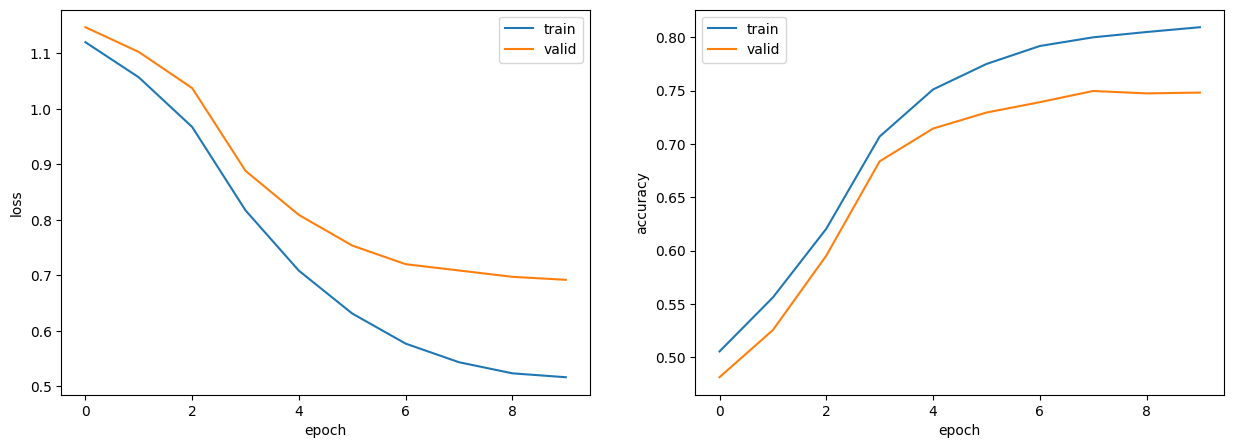

正解率（学習データ）：0.809
正解率（評価データ）：0.772


In [11]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

83.ミニバッチ化・GPU上での学習

In [12]:
class Padsequence():
    # ミニバッチごとに最大系列長でパディング
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

In [13]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2973, accuracy_train: 0.4085, loss_valid: 1.3227, accuracy_valid: 0.4115, 7.9786sec
epoch: 2, loss_train: 1.1572, accuracy_train: 0.5106, loss_valid: 1.1657, accuracy_valid: 0.4993, 7.2346sec
epoch: 3, loss_train: 1.2187, accuracy_train: 0.4580, loss_valid: 1.2288, accuracy_valid: 0.4558, 7.2229sec
epoch: 4, loss_train: 1.1429, accuracy_train: 0.5318, loss_valid: 1.1534, accuracy_valid: 0.5225, 7.2309sec
epoch: 5, loss_train: 1.1205, accuracy_train: 0.5558, loss_valid: 1.1449, accuracy_valid: 0.5480, 7.2140sec
epoch: 6, loss_train: 1.1675, accuracy_train: 0.5198, loss_valid: 1.2078, accuracy_valid: 0.5007, 7.2299sec
epoch: 7, loss_train: 1.0853, accuracy_train: 0.5830, loss_valid: 1.1173, accuracy_valid: 0.5607, 7.2081sec
epoch: 8, loss_train: 1.0689, accuracy_train: 0.5951, loss_valid: 1.0909, accuracy_valid: 0.5787, 7.1963sec
epoch: 9, loss_train: 1.0606, accuracy_train: 0.5979, loss_valid: 1.0818, accuracy_valid: 0.5810, 7.1535sec
epoch: 10, loss_train: 1.058

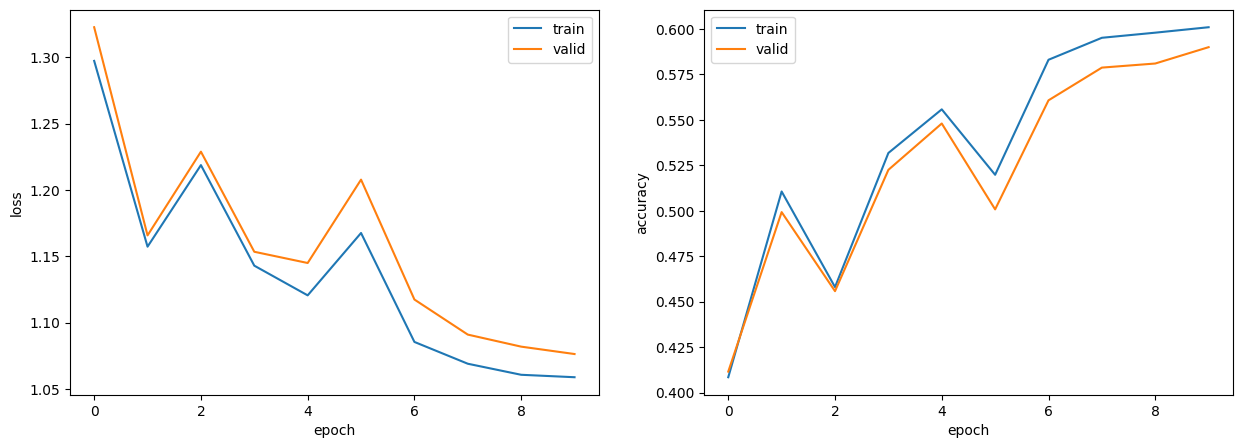

正解率（学習データ）：0.601
正解率（評価データ）：0.615


In [14]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

84.単語ベクトルの導入

In [15]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('../NLP100_70~79/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9042 / 9724
torch.Size([9724, 300])


In [16]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, device):
        hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
        return hidden

In [17]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2302, accuracy_train: 0.4012, loss_valid: 1.2582, accuracy_valid: 0.3988, 7.2033sec
epoch: 2, loss_train: 1.1629, accuracy_train: 0.4654, loss_valid: 1.1817, accuracy_valid: 0.4535, 7.1003sec
epoch: 3, loss_train: 1.1532, accuracy_train: 0.4737, loss_valid: 1.1528, accuracy_valid: 0.4858, 7.1944sec
epoch: 4, loss_train: 1.1738, accuracy_train: 0.4959, loss_valid: 1.2023, accuracy_valid: 0.4850, 7.2095sec
epoch: 5, loss_train: 1.1402, accuracy_train: 0.5395, loss_valid: 1.1707, accuracy_valid: 0.5157, 7.2414sec
epoch: 6, loss_train: 1.1686, accuracy_train: 0.5256, loss_valid: 1.2031, accuracy_valid: 0.4970, 7.2437sec
epoch: 7, loss_train: 1.0499, accuracy_train: 0.5923, loss_valid: 1.0737, accuracy_valid: 0.5795, 7.2059sec
epoch: 8, loss_train: 1.1455, accuracy_train: 0.5464, loss_valid: 1.1895, accuracy_valid: 0.5142, 7.1981sec
epoch: 9, loss_train: 1.0679, accuracy_train: 0.5868, loss_valid: 1.1000, accuracy_valid: 0.5637, 7.2023sec
epoch: 10, loss_train: 1.109

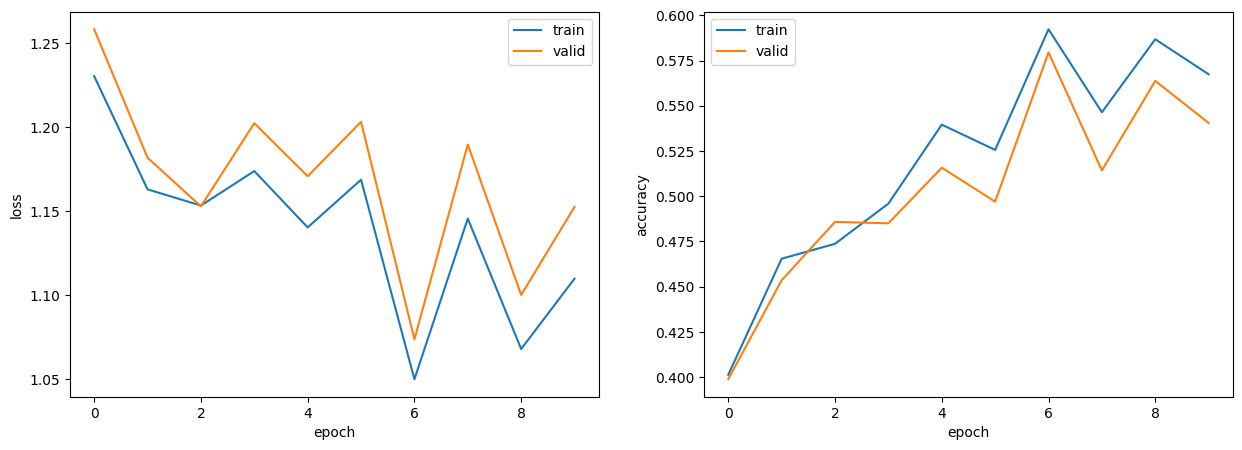

正解率（学習データ）：0.567
正解率（評価データ）：0.546


In [18]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

85.双方向RNN・多層化

In [19]:
# パラメータ
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数
criterion = nn.CrossEntropyLoss()

# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイス
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2143, accuracy_train: 0.3972, loss_valid: 1.2230, accuracy_valid: 0.3973, 8.0048sec
epoch: 2, loss_train: 1.2788, accuracy_train: 0.4082, loss_valid: 1.3146, accuracy_valid: 0.4018, 8.0270sec
epoch: 3, loss_train: 1.2610, accuracy_train: 0.4615, loss_valid: 1.3141, accuracy_valid: 0.4370, 8.0252sec
epoch: 4, loss_train: 1.2642, accuracy_train: 0.4677, loss_valid: 1.3007, accuracy_valid: 0.4498, 8.0568sec
epoch: 5, loss_train: 1.2222, accuracy_train: 0.4971, loss_valid: 1.2617, accuracy_valid: 0.4835, 8.1035sec
epoch: 6, loss_train: 1.0962, accuracy_train: 0.5576, loss_valid: 1.1325, accuracy_valid: 0.5390, 8.0596sec
epoch: 7, loss_train: 1.0413, accuracy_train: 0.5945, loss_valid: 1.0660, accuracy_valid: 0.5697, 8.0566sec
epoch: 8, loss_train: 1.1027, accuracy_train: 0.5644, loss_valid: 1.1458, accuracy_valid: 0.5427, 8.0570sec
epoch: 9, loss_train: 1.0639, accuracy_train: 0.5839, loss_valid: 1.1093, accuracy_valid: 0.5585, 8.0361sec
epoch: 10, loss_train: 1.111

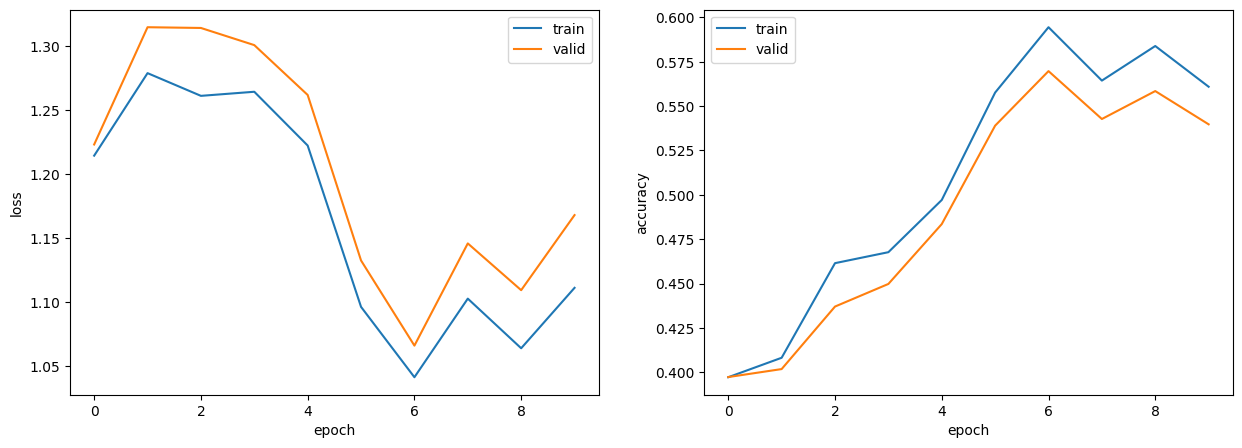

正解率（学習データ）：0.561
正解率（評価データ）：0.552


In [20]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

86.畳み込みニューラルネットワーク（CNN）

In [21]:
from torch.nn import functional as F

In [22]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.fc = nn.Linear(out_channels, output_size)
    
    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = self.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        out = self.fc(max_pool.squeeze(2))
        return out

In [23]:
# パラメータ
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2795, 0.2651, 0.2282, 0.2273]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2705, 0.2494, 0.2366, 0.2435]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2677, 0.2545, 0.2375, 0.2403]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2729, 0.2468, 0.2291, 0.2512]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2731, 0.2452, 0.2461, 0.2357]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2734, 0.2462, 0.2295, 0.2509]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2799, 0.2407, 0.2261, 0.2533]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2735, 0.2533, 0.2359, 0.2372]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2774, 0.2460, 0.2317, 0.2450]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2721, 0.2510, 0.2306, 0.2463]], grad_fn=<SoftmaxBackward0>)


87.確率的勾配降下法によるCNNの学習

In [24]:
# パラメータ
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数
criterion = nn.CrossEntropyLoss()

# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイス
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0753, accuracy_train: 0.5781, loss_valid: 1.0769, accuracy_valid: 0.5922, 8.0766sec
epoch: 2, loss_train: 1.0035, accuracy_train: 0.6480, loss_valid: 1.0187, accuracy_valid: 0.6177, 6.2532sec
epoch: 3, loss_train: 0.9341, accuracy_train: 0.6810, loss_valid: 0.9616, accuracy_valid: 0.6567, 6.2717sec
epoch: 4, loss_train: 0.8732, accuracy_train: 0.7083, loss_valid: 0.9116, accuracy_valid: 0.6844, 6.2941sec
epoch: 5, loss_train: 0.8265, accuracy_train: 0.7178, loss_valid: 0.8787, accuracy_valid: 0.6844, 6.2633sec
epoch: 6, loss_train: 0.7879, accuracy_train: 0.7382, loss_valid: 0.8509, accuracy_valid: 0.7024, 6.3417sec
epoch: 7, loss_train: 0.7646, accuracy_train: 0.7436, loss_valid: 0.8351, accuracy_valid: 0.7031, 7.2435sec
epoch: 8, loss_train: 0.7496, accuracy_train: 0.7521, loss_valid: 0.8243, accuracy_valid: 0.7106, 6.2898sec
epoch: 9, loss_train: 0.7433, accuracy_train: 0.7535, loss_valid: 0.8196, accuracy_valid: 0.7136, 6.2640sec
epoch: 10, loss_train: 0.741

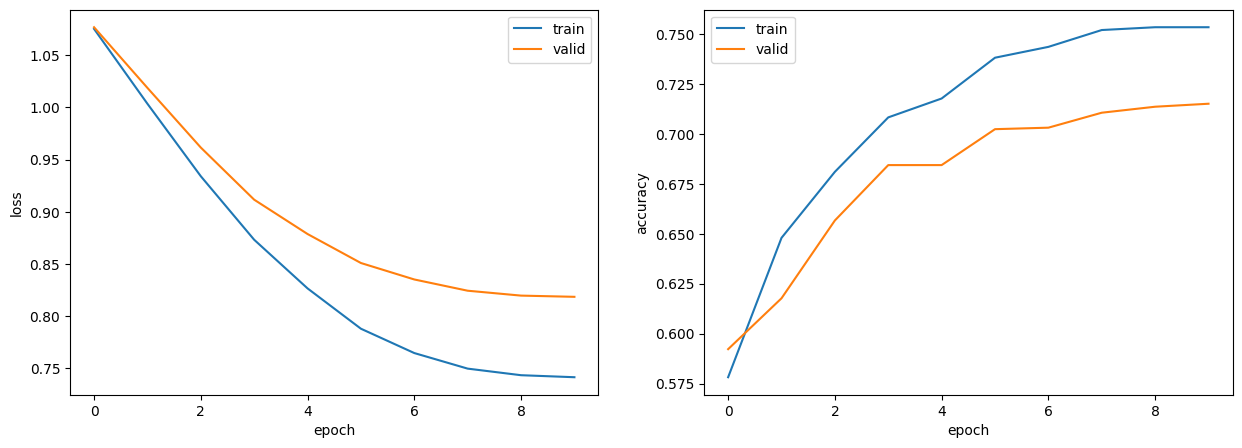

正解率（学習データ）：0.753
正解率（評価データ）：0.720


In [25]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

88.パラメータチューニング

In [31]:
class newCNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, drop_rate, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Linear(out_channels, output_size)
    
    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = self.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        out = self.fc(self.drop(max_pool.squeeze(2)))
        return out

In [32]:
# パラメータ
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 150
KERNEL_HEIGHTS = 3
DROP_RATE = 0.4
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-3
BATCH_SIZE = 128
NUM_EPOCHS = 30

# モデルの定義
model = newCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, DROP_RATE, emb_weights=weights)

# 損失関数
criterion = nn.CrossEntropyLoss()

# オプティマイザ
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# デバイス
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 0.7009, accuracy_train: 0.7525, loss_valid: 0.7885, accuracy_valid: 0.7136, 6.4003sec
epoch: 2, loss_train: 0.4848, accuracy_train: 0.8351, loss_valid: 0.6967, accuracy_valid: 0.7286, 6.3724sec
epoch: 3, loss_train: 0.3061, accuracy_train: 0.9073, loss_valid: 0.6167, accuracy_valid: 0.7729, 6.3936sec
epoch: 4, loss_train: 0.2126, accuracy_train: 0.9403, loss_valid: 0.6183, accuracy_valid: 0.7766, 6.4421sec
epoch: 5, loss_train: 0.1599, accuracy_train: 0.9525, loss_valid: 0.6062, accuracy_valid: 0.7834, 6.4270sec
epoch: 6, loss_train: 0.1098, accuracy_train: 0.9766, loss_valid: 0.5781, accuracy_valid: 0.8006, 6.3587sec
epoch: 7, loss_train: 0.0861, accuracy_train: 0.9850, loss_valid: 0.6006, accuracy_valid: 0.7946, 6.3605sec
epoch: 8, loss_train: 0.0747, accuracy_train: 0.9856, loss_valid: 0.6238, accuracy_valid: 0.7984, 6.3568sec
epoch: 9, loss_train: 0.0582, accuracy_train: 0.9915, loss_valid: 0.6158, accuracy_valid: 0.8006, 6.4103sec
epoch: 10, loss_train: 0.050

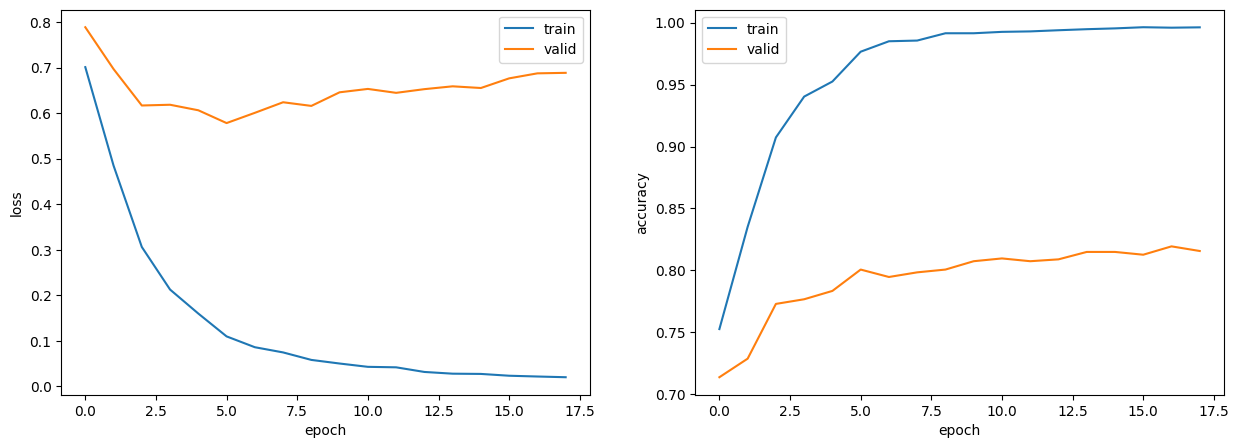

正解率（学習データ）：0.996
正解率（評価データ）：0.832


In [33]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

89.事前学習済み言語モデルからの転移学習

In [34]:
import transformers
from transformers import BertTokenizer, BertModel
from torch import optim

/home/sugihara/anaconda3/envs/NLP100/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# Datasetの定義
class createDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [36]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = createDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = createDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = createDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101,  6796, 12170, 22669,  2104,  4812,  2005,  4692, 13742,  2012,
         4913, 18396,  2015,   102,     0,     0,     0,     0,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])
labels: tensor([0., 1., 0., 0.])


/home/sugihara/anaconda3/envs/NLP100/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定
    
  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

In [38]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  # 損失・正解率を計算
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # モデルの学習を実行し、損失・正解率のログを返す
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [39]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, loss_train: 0.0854, accuracy_train: 0.9540, loss_valid: 0.0999, accuracy_valid: 0.9363, 29.5147sec
epoch: 2, loss_train: 0.0469, accuracy_train: 0.9758, loss_valid: 0.0960, accuracy_valid: 0.9333, 29.2609sec
epoch: 3, loss_train: 0.0303, accuracy_train: 0.9857, loss_valid: 0.0971, accuracy_valid: 0.9333, 29.4533sec
epoch: 4, loss_train: 0.0218, accuracy_train: 0.9907, loss_valid: 0.0951, accuracy_valid: 0.9378, 29.5085sec


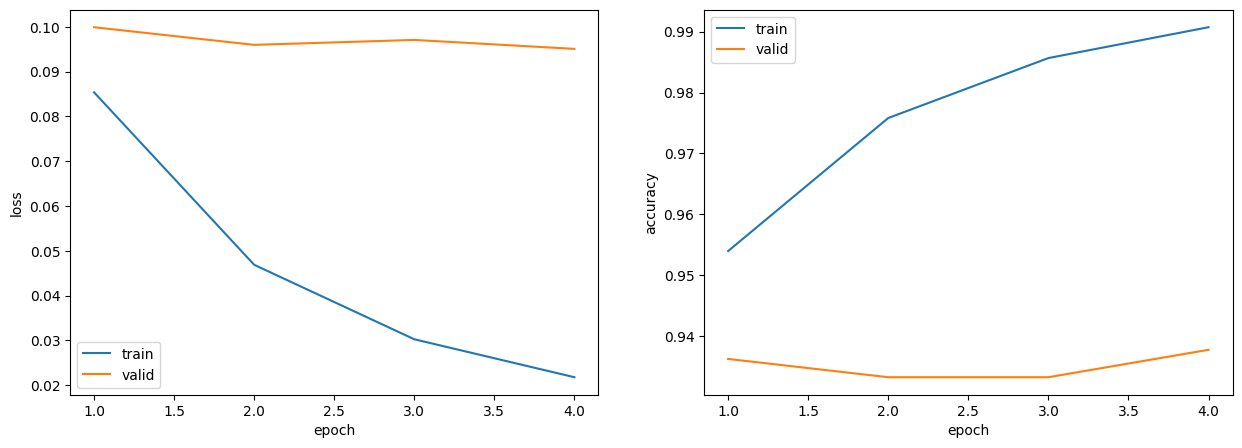

In [40]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [41]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

正解率（学習データ）：0.991
正解率（検証データ）：0.938
正解率（評価データ）：0.934
